In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_moons
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.linear_model import LogisticRegression

# Red RBF (Moody-Darken)

C:\Users\gsent\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


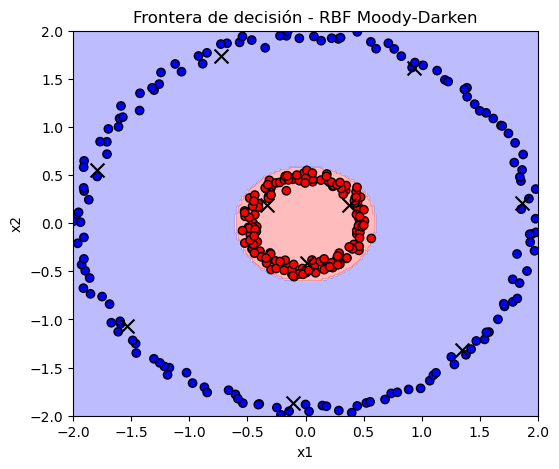

In [2]:
X, y = make_circles(n_samples=300, noise=0.02, factor=0.25, random_state=0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X_scaled)
centros = kmeans.cluster_centers_

D = cdist(centros, centros)
sigmas = np.mean(np.sort(D, axis=1)[:, 1:4], axis=1)

def rbf(X, centros, sigmas):
    Phi = np.zeros((X.shape[0], len(centros)))
    for i, c in enumerate(centros):
        Phi[:, i] = np.exp(-np.linalg.norm(X - c, axis=1) ** 2 / (2 * sigmas[i] ** 2))
    return Phi

Phi = rbf(X_scaled, centros, sigmas)
clf = LogisticRegression().fit(Phi, y)

xx, yy = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-2, 2, 200))
Xgrid = np.c_[xx.ravel(), yy.ravel()]
Phi_grid = rbf(scaler.transform(Xgrid), centros, sigmas)
Z = clf.predict(Phi_grid).reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='bwr')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors='k', cmap='bwr')
plt.scatter(centros[:, 0], centros[:, 1], c='black', s=100, marker='x')
plt.title("Frontera de decisión - RBF Moody-Darken")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Red Autoorganizada (Self Organized Map) 

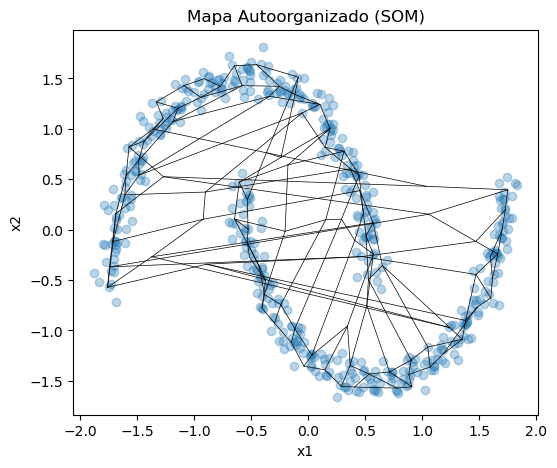

In [3]:
X, _ = make_moons(n_samples=500, noise=0.05, random_state=1)
X = scaler.fit_transform(X)

grid_size = 10
neurons = np.random.rand(grid_size, grid_size, 2)

lr = 0.5
epochs = 100
sigma0 = 2.0

def neighborhood(i, j, d):
    return [(x, y) for x in range(grid_size) for y in range(grid_size)
            if np.linalg.norm([i - x, j - y]) <= d]

for epoch in range(epochs):
    sigma = sigma0 * np.exp(-epoch / epochs)
    alpha = lr * np.exp(-epoch / epochs)
    for x in X:
        dists = np.linalg.norm(neurons - x, axis=2)
        winner = np.unravel_index(np.argmin(dists), dists.shape)
        for i, j in neighborhood(*winner, d=sigma):
            neurons[i, j] += alpha * (x - neurons[i, j])

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
for i in range(grid_size):
    for j in range(grid_size):
        if i < grid_size - 1:
            plt.plot([neurons[i, j, 0], neurons[i + 1, j, 0]],
                     [neurons[i, j, 1], neurons[i + 1, j, 1]], 'k-', lw=0.5)
        if j < grid_size - 1:
            plt.plot([neurons[i, j, 0], neurons[i, j + 1, 0]],
                     [neurons[i, j, 1], neurons[i, j + 1, 1]], 'k-', lw=0.5)
plt.title("Mapa Autoorganizado (SOM)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

# Red LVQ (Learning Vector Quantization)

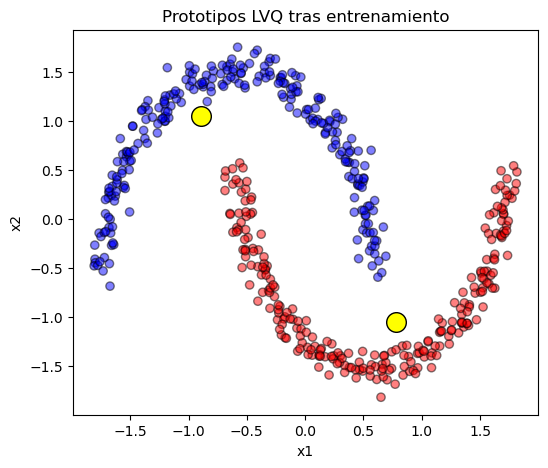

In [7]:
X, y = make_moons(n_samples=500, noise=0.05, random_state=0)
X = scaler.fit_transform(X)

prototypes = np.array([
    X[y == 0][0],
    X[y == 1][0]
])
labels = np.array([0, 1])

lr = 0.1
for epoch in range(20):
    for i in range(len(X)):
        dists = np.linalg.norm(prototypes - X[i], axis=1)
        winner = np.argmin(dists)
        if labels[winner] == y[i]:
            prototypes[winner] += lr * (X[i] - prototypes[winner])
        else:
            prototypes[winner] -= lr * (X[i] - prototypes[winner])

plt.figure(figsize=(6, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', alpha=0.5)
plt.scatter(prototypes[:, 0], prototypes[:, 1], c='yellow', s=200, edgecolors='black')
plt.title("Prototipos LVQ tras entrenamiento")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()